# N3OX Parasitic 20m 11-circle

This notebook is a quick and dirty first pass at using [`PyNEC`](https://pypi.org/project/PyNEC/) with [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to optimize a parasitic circle array. 

Inspired by [this thread on QRZ.com](https://forums.qrz.com/index.php?threads/two-theoretical-optimal-antenna-questions.717472/).

In [85]:
import platform
if not platform.node() in ['coriolis', 'axlotl']: #don't need to install on my local machines
    print(f'Platform node {platform.node()} needs package installs, please wait...')
    !pip install -q git+https://github.com/danzimmerman/n3ox_utils.git
    !pip install -q PyNEC==1.7.3.4
    print('... installation complete.')

import numpy as np
import matplotlib.pyplot as plt
import string
plt.rcParams.update({'font.size':20})
plot_colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
tables = {}
figs = {}

class plot_tools:
    """
    Simple box-of-functions class to collect plot manipulation methods.
    """
    def __init__(self):
        pass
    
    def gridfig(self, nrows, ncols, rowheight=4, width=15):
        fig = plt.figure(figsize=(width, nrows*rowheight), facecolor='w')
        axs = fig.subplots(nrows, ncols)
        for ax, l in zip(axs.flatten(), string.ascii_lowercase):
            setattr(fig, f'ax{l}', ax)
        return fig

    def label_axes(self, fig, x=0.925, y=0.85):
        for ax, l in zip(fig.axes, string.ascii_lowercase):
            ax.annotate(l, xy=(x, y), xytext=(x, y), 
                        xycoords='axes fraction',
                    fontstyle='italic',
                    bbox={'facecolor':'w', 'alpha':0.5, 'boxstyle':'round'})
            
pt = plot_tools()

import n3ox_utils.pynec_helpers as pnh
import n3ox_utils.plot_tools as ptl
import PyNEC as pynec
from scipy.constants import speed_of_light as cee

from IPython.display import clear_output

import scipy.optimize as scopt

In [213]:
opt.optimization_result.x

array([8.06892683e-07, 3.17960678e-07, 9.97648858e-11, 1.44918900e-10,
       1.33885496e-14])

In [220]:
class CircleAntennaOptimizer(object):
    """
    Runs an optimization on an evenly-spaced circular array of half-wave dipoles
    to turn it into a parasitic directive array. 

    Each vertical has an odd quarter-wave feedline stub. 

    Parasitics are terminated in a reactance.
    """
    def __init__(self, frequency_MHz=14, number_of_elements=11, 
                 array_radius=9, element_height=None,
                 segments_per_element=17, wire_radius=0.0125):
        """
        frequency_MHz in MHz
        array_radius in meters
        element_height in meters

        If element_height is not specified, it's set to a free-space half wavelength

        Elements are numbered counterclockwise with #0 on the x-axis.

        Indices of driven elements (driven_tags) are 1-indexed starting at #1 on the x-axis.
        
        These are the NEC tag numbers.

        Each vertical dipole has segments_per_element segments.
        """
        self.context = None
        self.freq = float(frequency_MHz)
        self.N = int(number_of_elements)
        self.R = float(array_radius)
        self.rwire = float(wire_radius)
        if not element_height:
            self.height = cee/(self.freq*1e6)/2.0
        else:
            self.height = float(element_height)
        self.nsegs = int(segments_per_element)
        self.wires = []
        for n, ang in enumerate(np.linspace(0, 2*np.pi, self.N, endpoint=False)):
            x = self.R*np.cos(ang)
            y = self.R*np.sin(ang)
            wd = {'xw1':x, 'xw2':x, 
                  'yw1':y, 'yw2':y, 
                  'zw1':-self.height/2, 'zw2':self.height/2,
                  'rad':self.rwire, 
                  'tag_id':n+1, 'segment_count':self.nsegs,
                  'rdel':1, 'rrad':1}
            self.wires.append(wd)
            
        if not self.N==11:
            raise NotImplementedError('Optimizer target hardcoded to 11 elements for now! Sorry!')

    def gain_optimizer_target(self, reactances):
        """
        Defines the optimization target function.
        Hardcoded to five reactances for pairwise loading of 11-element array, 
        needs work for arbitrary elements.
        """
        L1, L2, C1, C2, C3 = reactances
        self.context = pynec.nec_context()
        self.geo = self.context.get_geometry()
        for wire in self.wires:
            self.geo.wire(**wire)
        self.context.geometry_complete(0)
        self.eltags = [[1], [2, 11], [3, 10], [4, 9], [5, 8], [6, 7]]
        self.elvals = [L1, L2, np.nan, C1, C2, C3]
        self.eltypes = ['L', 'L', 'driven', 'C', 'C', 'C']
        for tags, loadval, eltype in zip(self.eltags, self.elvals, self.eltypes):
            loadval = np.abs(loadval)
            if eltype == 'driven':
                for tag in tags:
                    exargs = pnh.pack_ex_card_args(excitation_type='voltage',
                                                   source_tag=tag, source_seg=self.nsegs//2, #integer divide
                                                   ereal=10.0, eimag=0.0)
                    self.context.ex_card(*exargs)
            elif eltype == 'L':
                for tag in tags:
                    ldargs = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                                   load_tag=tag,
                                                   load_seg_start=self.nsegs//2,
                                                   L=loadval, R=0, C=0)
                    self.context.ld_card(*ldargs)
            elif eltype == 'C':
                for tag in tags:
                    ldargs = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                                   load_tag=tag,
                                                   load_seg_start=self.nsegs//2,
                                                   C=loadval, R=0, L=0)
                    self.context.ld_card(*ldargs)
        
        frargs = [0, 1, self.freq, 0] #fr_card(ifrq, nfrq, freq_hz, del_freq)
        self.context.fr_card(*frargs)
        azpargs = {'calc_mode':0, 'normalization':5, 
          'n_theta':1, 'theta0':90, 'delta_theta':0,
          'n_phi':361, 'phi0':0, 'delta_phi':1, 
          'radial_distance':0, 'gain_norm':0,
          'output_format':0, 'D':0, 'A':0}
        self.context.rp_card(**azpargs)
        self.azpattern = self.context.get_radiation_pattern(0)
        self.gain = np.squeeze(self.azpattern.get_gain())
        self.azangs = self.azpattern.get_phi_angles()
        clear_output()
        print(f'\rCurrent gain: {self.gain[180]:.2f}dBi                 ')
        return -self.gain[180]
    
    def optimize(self, initial_guess=np.array([0.672e-6, 0.336e-6, 86.21e-12, 65.93e-12, 44.83e-12])):
        """
        Runs the optimization
        """
        self.optimization_result = scopt.minimize(fun=self.gain_optimizer_target, x0=initial_guess, 
                                                  method='Nelder-Mead')
        
    def show_result(self):
        """
        
        """
        fmts = []
        for lab, optval in zip(['L1', 'L2', 'C1', 'C2', 'C3'], self.optimization_result.x):
            if lab.count('L'):
                fmts.append(f'{optval/1e-6:.3f}uH')
            elif lab.count('C'):
                fmts.append(f'{optval/1e-12:.3f}pF')
        return '|'.join(fmts)
        

In [221]:
opt = CircleAntennaOptimizer(array_radius=9, frequency_MHz=14.150, segments_per_element=17, element_height=None)

In [222]:
opt.optimize()
opt.show_result()



Current gain: 12.16dBi                 


'0.807uH|0.318uH|99.765pF|144.919pF|0.013pF'

In [223]:
figs = {}

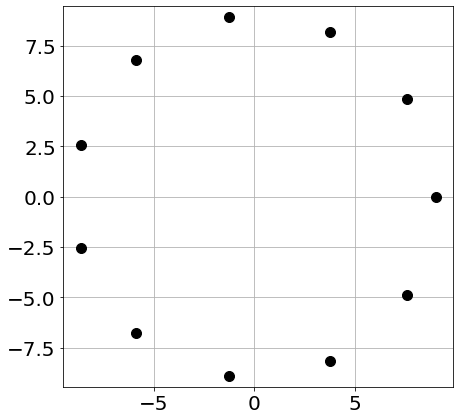

In [224]:
figs[1] = plt.figure(figsize=(7, 7))
figs[1].axa = figs[1].subplots(1, 1)
for wd in opt.wires:
    figs[1].axa.plot(wd['xw1'], wd['yw1'], marker='o', 
                     linestyle='None', color='k', markersize=10)
figs[1].axa.axis('equal')
figs[1].axa.grid()

_**Figure 1:** Array geometry in x, y plane_

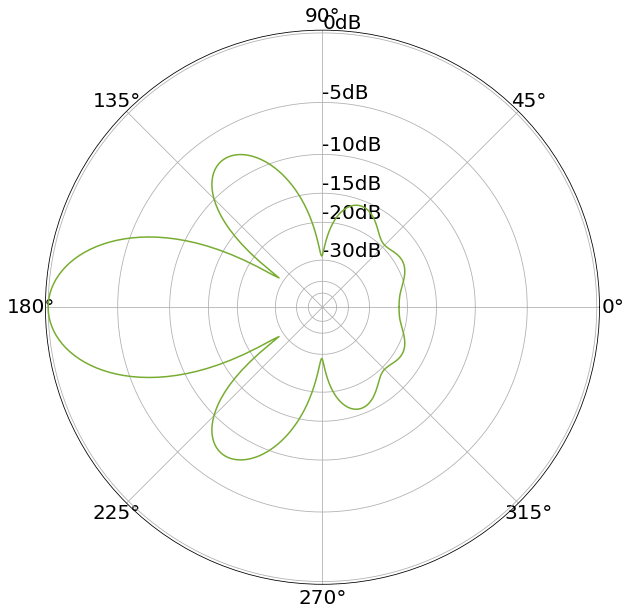

In [225]:
figs[2] = ptl.init_ARRL_polar_fig(plt, figsize=(9, 9))
ptl.add_ARRL_polar_plot(opt.azangs*np.pi/180,
                        10**(opt.gain/10), 
                        ax=figs[2].axa, color=ptl.plot_colors[5])

figs[2].tight_layout()

_**Figure 2:** Array azimuth plot at 14.150MHz optimization frequency._

Text(0.5, 0, 'z (m)')

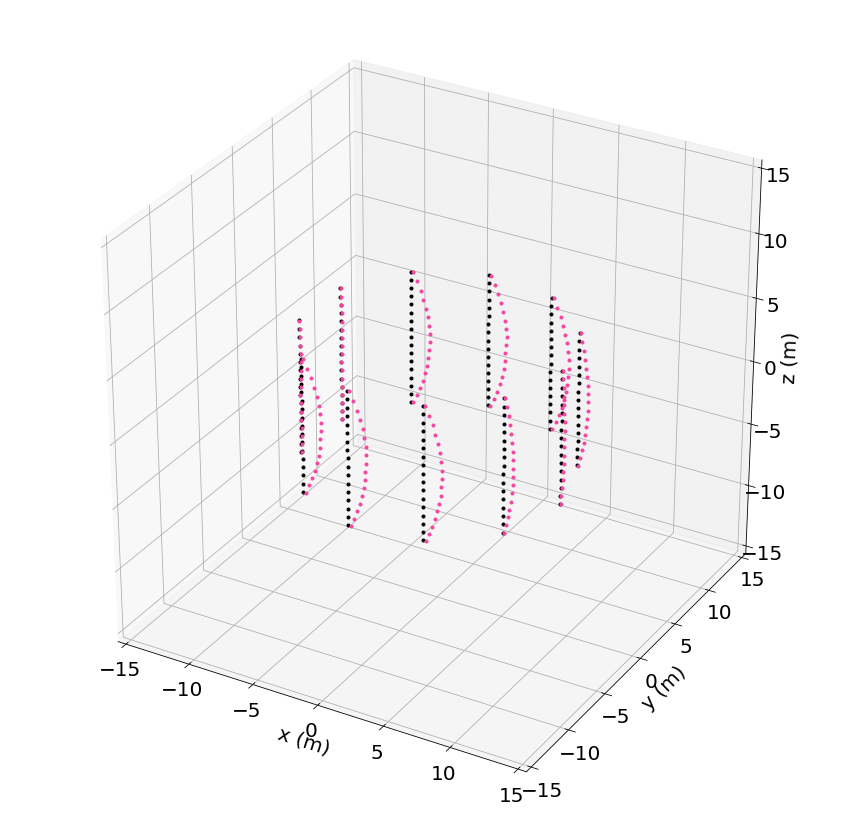

In [226]:
# --- Get structure currents --- 

opt.currdata = opt.context.get_structure_currents(0)
opt.currents = opt.currdata.get_current()

opt.currcoords = np.asarray([
                              22.10882284*opt.currdata.get_current_segment_center_x(),
                              22.10882284*opt.currdata.get_current_segment_center_y(),
                              22.10882284*opt.currdata.get_current_segment_center_z(),
                            ]).T

# --- Visualize current distribution ---
from mpl_toolkits.mplot3d import Axes3D # enables '3d' projection
figs[3] = plt.figure(figsize=(15,15))
figs[3].axa = figs[3].add_subplot(111, projection='3d')
ixsrc = 24

figs[3].axa.plot(opt.currcoords[0:ixsrc, 0],
                 opt.currcoords[0:ixsrc, 1],
                 opt.currcoords[0:ixsrc, 2],
                 color='k', linestyle='None', marker='.')

figs[3].axa.plot(opt.currcoords[ixsrc:, 0],
                 opt.currcoords[ixsrc:, 1],
                 opt.currcoords[ixsrc:, 2],
                 color='k', linestyle='None', marker='.')

curoptale = 0.1
figs[3].axa.plot(opt.currcoords[0:ixsrc, 0]+np.abs(opt.currents[0:ixsrc])/curoptale,
                 opt.currcoords[0:ixsrc, 1],
                 opt.currcoords[0:ixsrc, 2],
                 color='#f7459e', linestyle='None', marker='.')

figs[3].axa.plot(opt.currcoords[ixsrc:, 0]+np.abs(opt.currents[ixsrc:])/curoptale,
                 opt.currcoords[ixsrc:, 1],
                 opt.currcoords[ixsrc:, 2],
                 color='#f7459e', linestyle='None', marker='.')
lims = [-15,15]
for limsetter in [figs[3].axa.set_xlim, figs[3].axa.set_ylim, figs[3].axa.set_zlim]:
    limsetter(lims)
figs[3].axa.set_xlabel('x (m)')
figs[3].axa.set_ylabel('y (m)')
figs[3].axa.set_zlabel('z (m)')

_**Figure 3:** Element currents_